In [1]:
import numpy as np
import tensorflow.keras
from tensorflow import keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle
import matplotlib.pyplot as plt
import math

In [2]:
val_theta = pd.read_csv("val_param.csv").values[:,1:-1]
test_theta = pd.read_csv("test_param.csv").values[:,1:-1]
print(val_theta.shape,test_theta.shape)

(7776, 5) (10000, 5)


In [3]:
def getsc(y, J):
	"""
	this function outputs scattering transform of a time-domain signal.
	"""
	N = len(y)
	scattering = Scattering1D(J=J, shape=(N,), Q=1, max_order=2)
	Sy = scattering(y)
	return Sy

def interpolate_sounds(x_coord,y_coord,num,prec,J,w,tau,p,D,alpha):
		"""
		x_coord, y_coord is the point at which you want to interpolate the sounds
		num is number of interpolation points
		prec is distance between interpolated to interpolation points
		"""
		scs = []
		sounds = []
		if num == 2:
			inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord)]
		elif num == 4:
			inter = [(x_coord+prec,y_coord),(x_coord-prec,y_coord),(x_coord,y_coord+prec),(x_coord,y_coord-prec)]
		for (x,y) in inter:
			y = hitdifferentparts.hitdiffparts(x,y,w,tau,p,D,alpha)
			Sy = getsc(torch.Tensor(y),J)
			sounds.append(y)
			scs.append(Sy)
		return sum(scs)/float(num),sounds

try to find a representation that is stable to noise addition Sx

In [4]:
import ftm
w,t,pp,d,a = val_theta[1,:]
#original audio
sound,sr = librosa.load("/scratch/hh2263/drum_data/val/22223_sound.wav") 
#add delta at front
sound1 = np.copy(sound)
sound1[:1000] = sound[:1000] + 0.9
#perturb noise to 10% its original signal value
sound2 = sound + np.random.random(2**15)*sound*0.1
#algorithm
sound3 = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=22050)[:2**15]
sound3 = sound3/ max(sound3)
#longer sound
sound4 = ftm.getsounds_imp(10,10,w,t*1.5,pp,d,a,sr=22050)[:2**15]
sound4 = sound4/ max(sound4)

In [5]:
#scale sound by 2 
sound5 = np.copy(sound)/2

In [66]:
w,t,pp,d,a = val_theta[0,:]
#original audio
sound,sr = librosa.load("/scratch/hh2263/drum_data/val/22222_sound.wav") 

sound3 = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=22050)[:2**15]
sound3 = sound3/ max(sound3)
print(sound[0]-sound3[0],sound[1]-sound3[1],sound3[0:3],sound[0:3])

0.010315708816051483 -0.0022172895356931677 [0.         0.11492674 0.21987306] [0.01031571 0.11270945 0.22115575]


In [67]:
w,t,pp,d,a = val_theta[1,:]
#original audio
sound,sr = librosa.load("/scratch/hh2263/drum_data/val/22223_sound.wav") 

sound3 = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=22050)[:2**15]
sound3 = sound3/ max(sound3)
print(sound[0]-sound3[0],sound[1]-sound3[1],sound3[0:3],sound[0:3])

0.009173296391963959 -0.0019636340309582834 [0.         0.10292627 0.19722386] [0.0091733  0.10096264 0.19835451]


In [95]:
w,t,pp,d,a = val_theta[2,:]
#original audio
sound,sr = librosa.load("/scratch/hh2263/drum_data/val/22224_sound.wav") 

sound3 = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=22050)[:2**15]
sound3 = sound3/ max(sound3)
print(sound[0]-sound3[0],sound[1]-sound3[1],sound3[0:3],sound[0:3])

0.011941456235945225 -0.002516039506076845 [0.         0.13372921 0.25490377] [0.01194146 0.13121317 0.25634778]


In [6]:
#keep back of algorithm & original audio same
sound6 = np.copy(sound3)
sound6[:2**14] = sound[:2**14]
#keep front of algorithm & original audio same
sound7 = np.copy(sound3)
sound7[2**14:] = sound[2**14:]
#find average of the algorithm and original audio
sound8 = (sound+sound3)/2

In [7]:
#difference implementation
sound9 = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=44100)
sound9 = sound9/max(sound9)
sound9 = (sound9[::2]+sound9[1::2])/2

In [99]:
ipd.Audio(sound9,rate=22050)

In [105]:
print(sound[0:3],sound9[0:3])

[0.01194146 0.13121317 0.25634778] [0.03408589 0.16468012 0.28436717]


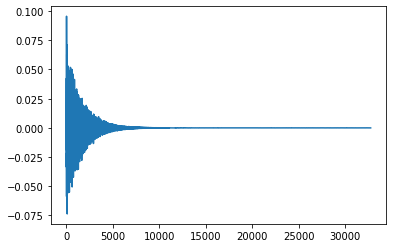

In [104]:
plt.plot(sound-sound9)

In [26]:
ipd.Audio(sound-sound6,rate=sr)

In [17]:
ipd.Audio(sound-sound7,rate=sr)

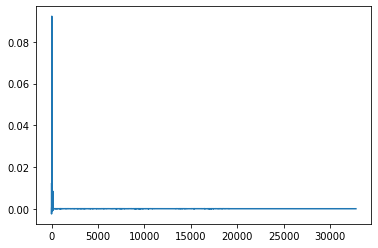

In [94]:
plt.plot(sound-sound3)

In [23]:
d

0.00276465753558694

In [63]:
sound10 = ftm.getsounds_imp(10,10,w,t*0.1,pp*5,d,a,sr=22050)[:2**15]
sound10 = sound10/ max(sound10)

In [64]:
eps=1e-1
j=8
Sc = getsc(torch.Tensor(sound),j)
Sc = np.log1p(((Sc>0)*Sc)/eps)
Sc1 = getsc(torch.Tensor(sound1),j)
Sc1 = np.log1p(((Sc1>0)*Sc1)/eps)
Sc2 = getsc(torch.Tensor(sound2),j)
Sc2 = np.log1p(((Sc2>0)*Sc2)/eps)
Sc3 = getsc(torch.Tensor(sound3),j)
Sc3 = np.log1p(((Sc3>0)*Sc3)/eps)
Sc4 = getsc(torch.Tensor(sound4),j)
Sc4 = np.log1p(((Sc4>0)*Sc4)/eps)
Sc5 = getsc(torch.Tensor(sound5),j)
Sc5 = np.log1p(((Sc5>0)*Sc5)/eps)
Sc6 = getsc(torch.Tensor(sound6),j)
Sc6 = np.log1p(((Sc6>0)*Sc6)/eps)
Sc7 = getsc(torch.Tensor(sound7),j)
Sc7 = np.log1p(((Sc7>0)*Sc7)/eps)
Sc8 = getsc(torch.Tensor(sound8),j)
Sc8 = np.log1p(((Sc8>0)*Sc8)/eps)
Sc9 = getsc(torch.Tensor(sound9),j)
Sc9 = np.log1p(((Sc9>0)*Sc9)/eps)
Sc10 = getsc(torch.Tensor(sound10),j)
Sc10 = np.log1p(((Sc10>0)*Sc10)/eps)

In [65]:
#original difference, first half smae diff, second half same diff, avg diff, manipulate sound diff, another sound diff
print(np.linalg.norm(Sc-Sc3),np.linalg.norm(Sc-Sc6),np.linalg.norm(Sc-Sc7),np.linalg.norm(Sc-Sc8),np.linalg.norm(Sc-Sc9),np.linalg.norm(Sc-Sc10))

0.00045025576 0.0003091018 0.00032724917 0.00023074314 0.0046795993 2.2918916


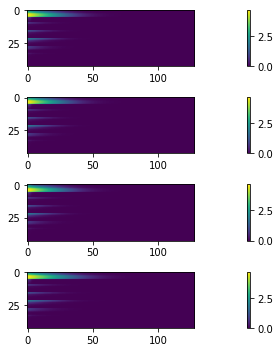

In [54]:
plt.figure(figsize=(15,5))
plt.subplot(4,1,1)
plt.imshow((Sc)) #algorithm change
plt.colorbar()
plt.subplot(4,1,2)
plt.imshow((Sc6)) #first half same
plt.colorbar()
plt.subplot(4,1,3)
plt.imshow((Sc7)) #latter half same
plt.colorbar()
plt.subplot(4,1,4)
plt.imshow((Sc10)) #averaged change
plt.colorbar()
plt.tight_layout()
plt.show()

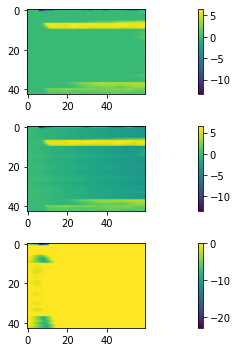

In [126]:
plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
plt.imshow((Sc)) #algorithm change
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow((Sc-Sc4)) #duration change
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow((Sc-Sc1)) #impulse change
plt.colorbar()
plt.tight_layout()
plt.show()

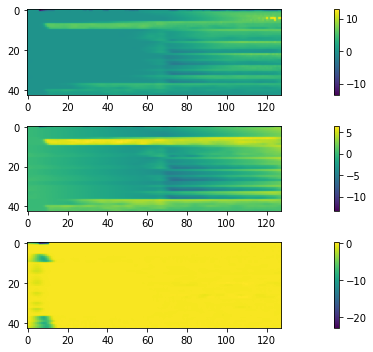

In [121]:
plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
plt.imshow(Sc-Sc3) #algorithm change
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(Sc-Sc4) #duration change
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(Sc-Sc1) #impulse change
plt.colorbar()
plt.tight_layout()
plt.show()

In [86]:
abs(Sc-Sc3)/Sc

tensor([[6.9261e-03, 7.0915e-03, 7.5601e-03,  ...,       -inf,        nan,
               -inf],
        [1.8265e-04, 1.5718e-04, 9.9092e-05,  ..., 9.9456e-01, 9.9457e-01,
         9.9500e-01],
        [3.2375e-04, 2.7733e-04, 1.7249e-04,  ..., 9.9726e-01, 9.9781e-01,
         9.9781e-01],
        ...,
        [1.8921e-02, 1.9581e-02, 2.1351e-02,  ..., 9.8456e-01, 9.8230e-01,
         9.6939e-01],
        [2.2259e-02, 2.2743e-02, 2.4046e-02,  ..., 9.8374e-01, 9.6610e-01,
         9.4828e-01],
        [3.6709e-02, 3.7015e-02, 3.7792e-02,  ..., 9.9441e-01, 9.8985e-01,
         9.9029e-01]])

In [80]:
print(sum(sum((Sc-Sc3)/Sc)),sum(sum(Sc)),sum(sum(Sc-Sc4)))

tensor(nan) tensor(2633.9353) tensor(-1058.0442)


In [62]:
#try plotting spectrogram
import librosa


spec = librosa.amplitude_to_db(np.abs(librosa.stft(sound)), ref=np.max)
spec1 = librosa.amplitude_to_db(np.abs(librosa.stft(sound1)), ref=np.max)
spec2 = librosa.amplitude_to_db(np.abs(librosa.stft(sound2)), ref=np.max)
spec3 = librosa.amplitude_to_db(np.abs(librosa.stft(sound3)), ref=np.max)
spec4 = librosa.amplitude_to_db(np.abs(librosa.stft(sound4)), ref=np.max)
spec5 = librosa.amplitude_to_db(np.abs(librosa.stft(sound5)), ref=np.max)


In [63]:
import librosa.display

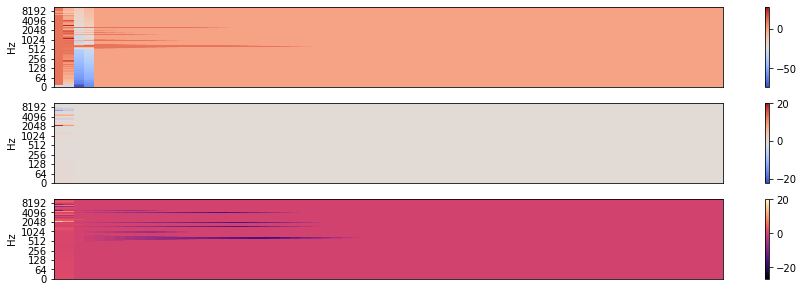

In [92]:
plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
librosa.display.specshow(spec-spec1, y_axis='log')
plt.colorbar()
plt.subplot(3,1,2)
librosa.display.specshow(spec-spec3, y_axis='log')
plt.colorbar()
plt.subplot(3,1,3)
librosa.display.specshow(spec-spec4, y_axis='log')
plt.colorbar()

In [54]:
np.log(spec)-np.log(spec3)

array([[ 0.04735112,  0.04589963,  3.0043993 , ..., 22.287483  ,
        16.067577  , 15.371435  ],
       [ 0.04779148,  0.04880643,  2.3339267 , ..., 21.595556  ,
        15.375218  , 14.665687  ],
       [ 0.04751992,  0.04764807, -0.30719805, ..., 16.888977  ,
        10.390937  , 10.114252  ],
       ...,
       [-0.6994424 , -0.699595  ,  4.171509  , ..., 21.53733   ,
        14.160038  , 14.179162  ],
       [-0.70007706, -0.7001834 ,  4.250967  , ..., 20.71695   ,
        14.28581   , 14.238055  ],
       [-0.70027494, -0.70035815,  1.73775   , ..., 20.000505  ,
        14.218684  , 14.249434  ]], dtype=float32)

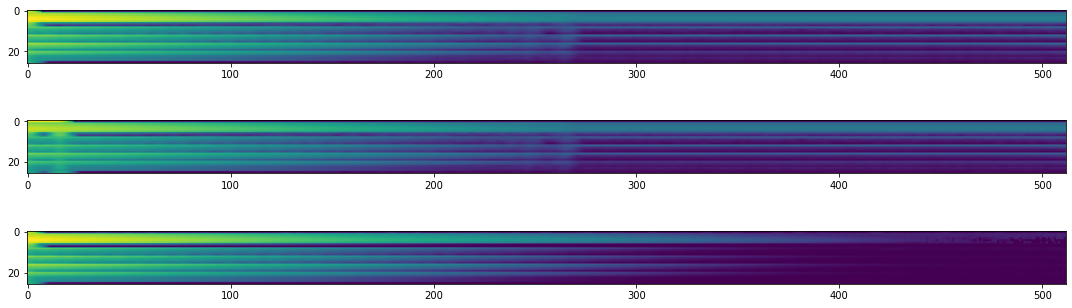

In [75]:
plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
plt.imshow(Sc)
#plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(Sc1)
#plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(Sc3)
#plt.colorbar()
plt.tight_layout()
plt.show()

In [92]:
print(sum(sum(((Sc4-Sc)[:,:256]))),sum(sum(((Sc4-Sc)[:,256:]))))


tensor(7831.9360) tensor(1375.9209)


In [93]:
print(sum(sum(((Sc3-Sc)[:,:256]))),sum(sum(((Sc3-Sc)[:,256:]))))

tensor(-1373.7692) tensor(-14026.4600)


In [75]:
import ftm
w,t,pp,d,a = val_theta[1,:]
#load original sound
sound,sr = librosa.load("/scratch/hh2263/drum_data/val/22223_sound.wav") # file is synthesized with 44100 and 2**16, but somehow with 22050 and 2**15, sounds the same with 44100 and 2**15
Sy_original = getsc(torch.Tensor(sound),8)
Sy_original_log = np.log1p(((Sy_original>0)*Sy_original)/1e-11)
#make rate=22050 gaussian excitation
y_acc2 = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=22050)[:2**15]
y_acc2 = y_acc2/ max(y_acc2)
Sy_acc2 = getsc(torch.Tensor(y_acc2),8)
Sy_acc_log2 = np.log1p(((Sy_acc2>0)*Sy_acc2)/1e-11)
#interpolated feature
Sy_interpolated,sounds = interpolate_sounds(0.5,0.5,4,0.05,8,w,t,pp,d,a)
Sy_interpolated_log = np.log1p(((Sy_interpolated>0)*Sy_interpolated)/1e-11)
#accurate feature_gaus
y_acc = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=44100)[::2]
y_acc = y_acc/ max(y_acc)
Sy_acc = getsc(torch.Tensor(y_acc),8)
Sy_acc_log = np.log1p(((Sy_acc>0)*Sy_acc)/1e-11)
#accurate feature_delta
y_hit = hitdifferentparts.hitdiffparts(0.5,0.5,w,t,pp,d,a) #5 modes, 2**15,delta excitation
Sy_hit = getsc(torch.Tensor(y_hit),8)
Sy_hit_log = np.log1p(((Sy_hit>0)*Sy_hit)/1e-11)
#accurate feature_pickle
pkl_dir = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/'
J = 8
Q = 1
order = 2
pickle_name = "_".join(
	["scattering",
	"J-" + str(J).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(order)]
)
pkl_path_val = os.path.join(pkl_dir,pickle_name+"_fold-val.pkl")
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
Sy_pik = Sy_val[1,:,:]
#Sy_pik = np.log1p(((Sy_pik>0)*Sy_pik)/1e-11)

--- 1.03737211227417 seconds ---
--- 1.0374393463134766 seconds ---
--- 1.0344901084899902 seconds ---
--- 1.033806324005127 seconds ---
--- 1.0375430583953857 seconds ---


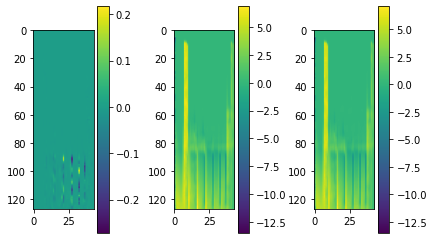

In [57]:
plt.subplot(1,3,1)
plt.imshow(torch.Tensor(Sy_pik)-Sy_original_log.T)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(torch.Tensor(Sy_pik)-Sy_acc_log.T)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(torch.Tensor(Sy_pik)-sc_new2.T)
plt.colorbar()
plt.tight_layout()
plt.show()

In [19]:
y_full = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=44100)
y_full = y_full/ max(y_full)
Sy_full = getsc(torch.Tensor(y_full),8)
Sy_full_log = np.log1p(((Sy_full>0)*Sy_full)/1e-11)

In [20]:
Sy_full_log.shape

torch.Size([43, 256])

how different are the scattering coefficients without log-scaling

In [21]:
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
Sy_pik = Sy_val[1,:,:]

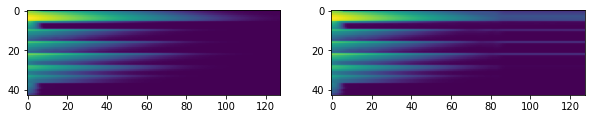

In [59]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.imshow(np.log1p(((Sy_acc>0)*Sy_acc)/1e-7))
#plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.log1p(((Sy_pik>0)*Sy_pik)/1e-7).T)
#plt.colorbar()

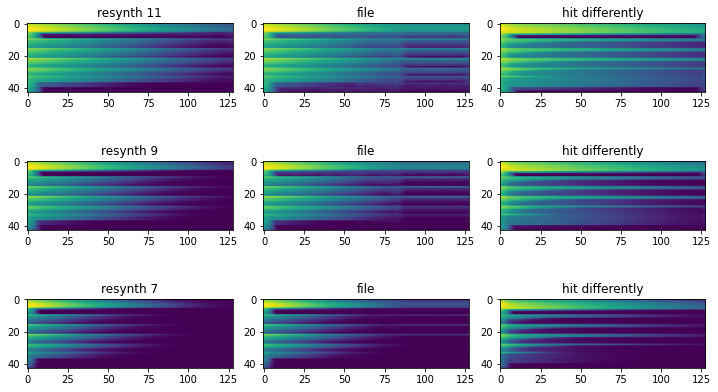

In [76]:
plt.figure(figsize=(10, 6))
plt.subplot(3,3,1)
plt.imshow(np.log1p(((Sy_acc>0)*Sy_acc)/1e-11))
plt.title("resynth 11")
#plt.colorbar()
plt.subplot(3,3,2)
plt.imshow(np.log1p(((Sy_pik>0)*Sy_pik)/1e-11).T)
plt.title("file")
plt.subplot(3,3,3)
plt.imshow(np.log1p(((Sy_hit>0)*Sy_hit)/1e-11))
plt.title("hit differently")
plt.subplot(3,3,4)
plt.imshow(np.log1p(((Sy_acc>0)*Sy_acc)/1e-9))
plt.title("resynth 9")
#plt.colorbar()
plt.subplot(3,3,5)
plt.imshow(np.log1p(((Sy_pik>0)*Sy_pik)/1e-9).T)
plt.title("file")
plt.subplot(3,3,6)
plt.imshow(np.log1p(((Sy_hit>0)*Sy_hit)/1e-9))
plt.title("hit differently")
plt.subplot(3,3,7)
plt.imshow(np.log1p(((Sy_acc>0)*Sy_acc)/1e-7))
plt.title("resynth 7")
#plt.colorbar()
plt.subplot(3,3,8)
plt.imshow(np.log1p(((Sy_pik>0)*Sy_pik)/1e-7).T)
plt.title("file")
plt.subplot(3,3,9)
plt.imshow(np.log1p(((Sy_hit>0)*Sy_hit)/1e-7))
plt.title("hit differently")
plt.tight_layout()

In [77]:
import ftm
w,t,pp,d,a = val_theta[2,:]
#load original sound
sound,sr = librosa.load("/scratch/hh2263/drum_data/val/22224_sound.wav") # file is synthesized with 44100 and 2**16, but somehow with 22050 and 2**15, sounds the same with 44100 and 2**15
Sy_original = getsc(torch.Tensor(sound),8)
Sy_original_log = np.log1p(((Sy_original>0)*Sy_original)/1e-11)
#make rate=22050 gaussian excitation
y_acc2 = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=22050)[:2**15]
y_acc2 = y_acc2/ max(y_acc2)
Sy_acc2 = getsc(torch.Tensor(y_acc2),8)
Sy_acc_log2 = np.log1p(((Sy_acc2>0)*Sy_acc2)/1e-11)
#interpolated feature
Sy_interpolated,sounds = interpolate_sounds(0.5,0.5,4,0.05,8,w,t,pp,d,a)
Sy_interpolated_log = np.log1p(((Sy_interpolated>0)*Sy_interpolated)/1e-11)
#accurate feature_gaus
y_acc = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=44100)[::2]
y_acc = y_acc/ max(y_acc)
Sy_acc = getsc(torch.Tensor(y_acc),8)
Sy_acc_log = np.log1p(((Sy_acc>0)*Sy_acc)/1e-11)
#accurate feature_delta
y_hit = hitdifferentparts.hitdiffparts(0.5,0.5,w,t,pp,d,a) #5 modes, 2**15,delta excitation
Sy_hit = getsc(torch.Tensor(y_hit),8)
Sy_hit_log = np.log1p(((Sy_hit>0)*Sy_hit)/1e-11)
#accurate feature_pickle
pkl_dir = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/'
J = 8
Q = 1
order = 2
pickle_name = "_".join(
	["scattering",
	"J-" + str(J).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(order)]
)
pkl_path_val = os.path.join(pkl_dir,pickle_name+"_fold-val.pkl")
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
Sy_pik = Sy_val[2,:,:]
#Sy_pik = np.log1p(((Sy_pik>0)*Sy_pik)/1e-11)

--- 1.037811517715454 seconds ---
--- 1.0316989421844482 seconds ---
--- 1.0323638916015625 seconds ---
--- 1.0301294326782227 seconds ---
--- 1.0444271564483643 seconds ---


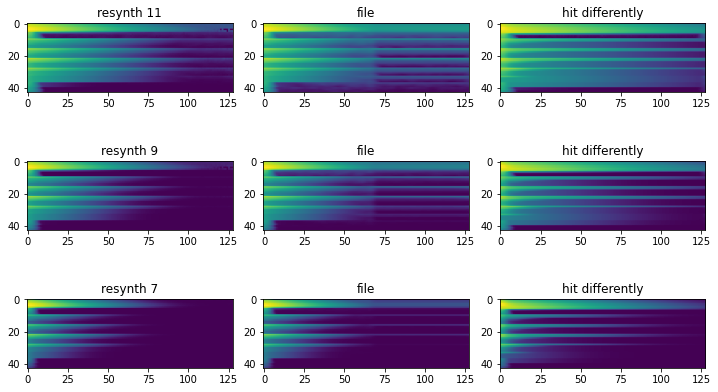

In [78]:
plt.figure(figsize=(10, 6))
plt.subplot(3,3,1)
plt.imshow(np.log1p(((Sy_acc>0)*Sy_acc)/1e-11))
plt.title("resynth 11")
#plt.colorbar()
plt.subplot(3,3,2)
plt.imshow(np.log1p(((Sy_pik>0)*Sy_pik)/1e-11).T)
plt.title("file")
plt.subplot(3,3,3)
plt.imshow(np.log1p(((Sy_hit>0)*Sy_hit)/1e-11))
plt.title("hit differently")
plt.subplot(3,3,4)
plt.imshow(np.log1p(((Sy_acc>0)*Sy_acc)/1e-9))
plt.title("resynth 9")
#plt.colorbar()
plt.subplot(3,3,5)
plt.imshow(np.log1p(((Sy_pik>0)*Sy_pik)/1e-9).T)
plt.title("file")
plt.subplot(3,3,6)
plt.imshow(np.log1p(((Sy_hit>0)*Sy_hit)/1e-9))
plt.title("hit differently")
plt.subplot(3,3,7)
plt.imshow(np.log1p(((Sy_acc>0)*Sy_acc)/1e-7))
plt.title("resynth 7")
#plt.colorbar()
plt.subplot(3,3,8)
plt.imshow(np.log1p(((Sy_pik>0)*Sy_pik)/1e-7).T)
plt.title("file")
plt.subplot(3,3,9)
plt.imshow(np.log1p(((Sy_hit>0)*Sy_hit)/1e-7))
plt.title("hit differently")
plt.tight_layout()

In [90]:
sum(sum(np.log1p(((Sy_pik>0)*Sy_pik)/1e-11).T - np.array(np.log1p(((Sy_acc>0)*Sy_acc)/1e-11))))

8729.386152267456

In [87]:
sum(sum(np.log1p(((Sy_pik>0)*Sy_pik)/1e-9).T - np.array(np.log1p(((Sy_acc>0)*Sy_acc)/1e-9))))

4209.4762717187405

In [89]:
sum(sum(np.log1p(((Sy_pik>0)*Sy_pik)/1e-7).T - np.array(np.log1p(((Sy_acc>0)*Sy_acc)/1e-7))))

1123.9768515378237

In [93]:
sum(sum(np.log1p(((Sy_pik>0)*Sy_pik)/1e-11).T - np.array(np.log1p(((Sy_hit>0)*Sy_hit)/1e-11))))

-1420.7721931934357

In [94]:
sum(sum(np.log1p(((Sy_pik>0)*Sy_pik)/1e-9).T - np.array(np.log1p(((Sy_hit>0)*Sy_hit)/1e-9))))

-1478.6772823035717

In [92]:
sum(sum(np.log1p(((Sy_pik>0)*Sy_pik)/1e-7).T - np.array(np.log1p(((Sy_hit>0)*Sy_hit)/1e-7))))

-735.6813180148602

In [47]:
y_acc_new = y_acc
y_acc_new[:10] = sound[:10]

In [48]:
ipd.Audio(y_acc_new,rate=22050)

In [52]:
ipd.Audio(sound,rate=22050)

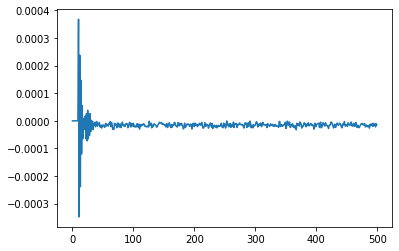

In [50]:
plt.plot((sound-y_acc)[:500])

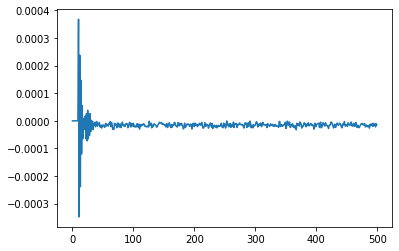

In [51]:
plt.plot((sound-y_acc_new)[:500])

In [53]:
sc_new2 = getsc(torch.Tensor(y_acc_new), 8)
sc_new2 = np.log1p(((sc_new2>0)*sc_new2)/1e-11)

In [9]:
y_new = ftm.getsounds_imp(10,10,w*1.1,t,pp,d,a,sr=22050)[:2**15]
y_new = y_new/max(y_new)
sc_new = getsc(torch.Tensor(y_new), 8)
sc_new = np.log1p(((sc_new>0)*sc_new)/1e-11)

y_p = ftm.getsounds_imp(10,10,w,t,pp*1.1,d,a,sr=22050)[:2**15]
y_p = y_p/max(y_p)
sc_p = getsc(torch.Tensor(y_p), 8)
sc_p = np.log1p(((sc_p>0)*sc_p)/1e-11)




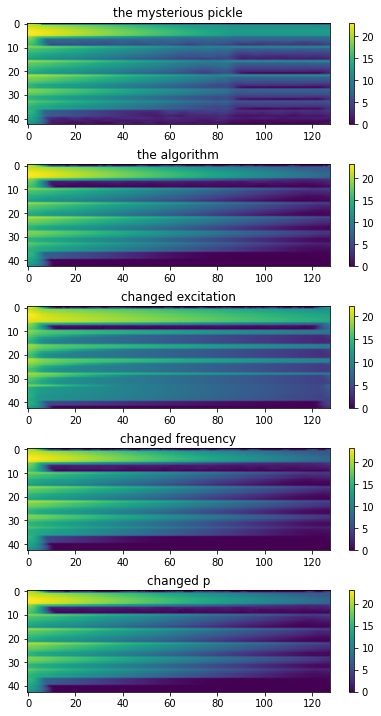

In [14]:
plt.figure(figsize=(6, 10))
plt.subplot(5,1,1)
plt.imshow(torch.Tensor(Sy_pik).T)
plt.title("the mysterious pickle")
plt.colorbar()
plt.subplot(5,1,2)
plt.imshow(Sy_acc_log)
plt.title("the algorithm")
plt.colorbar()
plt.subplot(5,1,3)
plt.imshow(Sy_hit_log)
plt.title("changed excitation")
plt.colorbar()
plt.subplot(5,1,4)
plt.title("changed frequency")
plt.imshow(sc_new)
plt.colorbar()
plt.subplot(5,1,5)
plt.title("changed p")
plt.imshow(sc_p)
plt.colorbar()
plt.tight_layout()
plt.show()

In [60]:
y = ftm.getsounds_imp(10,10,w,t,pp,d,a,sr=44100)
ipd.Audio(y,rate=44100)

In [61]:
ipd.Audio(sound,rate=22050)

In [65]:
S = getsc(torch.Tensor(y),8)
S = np.log1p(((S>0)*S)/1e-11)

In [68]:
S.shape

torch.Size([43, 256])

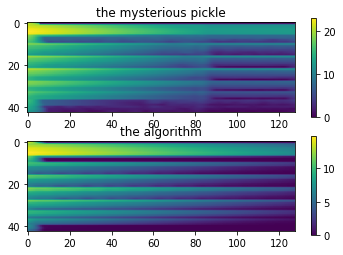

In [72]:
plt.subplot(2,1,1)
plt.imshow(torch.Tensor(Sy_pik).T)
plt.title("the mysterious pickle")
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(S[:,:128])
plt.title("the algorithm")
plt.colorbar()

In [73]:
w,t,pp,d,a = val_theta[1,:]
print(w,t,pp,d,a)

3630.6809028867247 0.09474440955182764 0.001536150703095199 0.00276465753558694 0.3166674016466726


In [74]:
w2,t2,pp2,d2,a2 = val_theta[2,:]
print(w2,t2,pp2,d2,a2)

4167.7970849803105 0.07472813760912253 0.0013854715545324233 0.0010892130105543585 0.4615867693580398


In [75]:
 pd.read_csv("val_param.csv").values

array([[22222, 3960.1349876368563, 0.09376144165196816, ...,
        0.0012821611585344935, 0.23768976773282824, 'val'],
       [22223, 3630.6809028867247, 0.09474440955182764, ...,
        0.00276465753558694, 0.3166674016466726, 'val'],
       [22224, 4167.7970849803105, 0.07472813760912253, ...,
        0.0010892130105543585, 0.4615867693580398, 'val'],
       ...,
       [77775, 9479.53744317422, 0.23568605392095315, ...,
        0.5060878946505472, 0.5833784977020442, 'val'],
       [77776, 9485.453520085452, 0.2315565337974155, ...,
        0.3270797573422091, 0.6279321315678661, 'val'],
       [77777, 10141.856678077043, 0.2299441296636509, ...,
        0.6690986317575044, 0.7806031702997823, 'val']], dtype=object)

In [78]:
sound2,sr2 = librosa.load("/scratch/hh2263/drum_data/val/22224_sound.wav") # file is synthesized with 44100 and 2**16, but somehow with 22050 and 2**15, sounds the same with 44100 and 2**15
Sy_original2 = getsc(torch.Tensor(sound2),8)
Sy_original_log2 = np.log1p(((Sy_original2>0)*Sy_original2)/1e-11)
#make rate=22050 gaussian excitation
y_acc2 = ftm.getsounds_imp(10,10,w2,t2,pp2,d2,a2,sr=22050)[:2**15]
y_acc2 = y_acc2/ max(y_acc2)
Sy_acc2 = getsc(torch.Tensor(y_acc2),8)
Sy_acc_log2 = np.log1p(((Sy_acc2>0)*Sy_acc2)/1e-11)


In [105]:
sound3,sr3 = librosa.load("/scratch/hh2263/drum_data/val/22222_sound.wav") # file is synthesized with 44100 and 2**16, but somehow with 22050 and 2**15, sounds the same with 44100 and 2**15
Sy_original3 = getsc(torch.Tensor(sound3),8)
Sy_original_log3 = np.log1p(((Sy_original3>0)*Sy_original3)/1e-11)
#make rate=22050 gaussian excitation
w3,t3,pp3,d3,a3 = val_theta[0,:]
y_acc3 = ftm.getsounds_imp(10,10,w3,t3,pp3,d3,a3,sr=22050)[:2**15]
y_acc3 = y_acc3/ max(y_acc3)
Sy_acc3 = getsc(torch.Tensor(y_acc3),8)
Sy_acc_log3 = np.log1p(((Sy_acc3>0)*Sy_acc3)/1e-11)



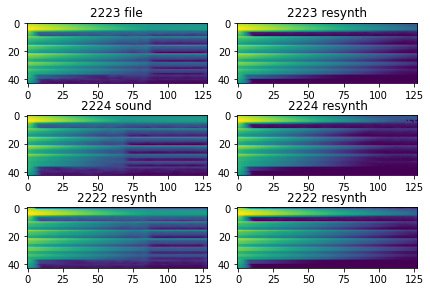

In [110]:
plt.subplot(3,2,1)
plt.imshow(Sy_original_log)
plt.title("2223 file")
#plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(Sy_acc_log)
plt.title("2223 resynth")
#plt.colorbar()
plt.subplot(3,2,3)
plt.imshow(Sy_original_log2)
plt.title("2224 sound")
#plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(Sy_acc_log2)
plt.title("2224 resynth")
#plt.colorbar()
plt.subplot(3,2,5)
plt.imshow(Sy_original_log3)
plt.title("2222 resynth")
#plt.colorbar()
plt.subplot(3,2,6)
plt.imshow(Sy_acc_log3)
plt.title("2222 resynth")
#plt.colorbar()
plt.tight_layout()

In [96]:
ipd.Audio(sound-y_acc,rate=22050)

In [123]:
ipd.Audio(sound,rate=22050)

In [119]:
ipd.Audio(y_acc,rate=22050)

In [179]:
noise = 0.001
sound_noise = sound-(np.random.random(2**15)*noise-noise/2)
Sy_noise = getsc(torch.Tensor(sound_noise),8)
Sy_noise = np.log1p(((Sy_noise>0)*Sy_noise)/1e-11)

In [167]:
sound_mode = ftm.getsounds_imp(15,15,w,t,pp,d,a,sr=22050)[:2**15]
Sy_mode = getsc(torch.Tensor(sound_mode),8)
Sy_mode = np.log1p(((Sy_mode>0)*Sy_mode)/1e-11)

In [174]:
sound_mode2 = ftm.getsounds_imp(5,5,w,t,pp,d,a,sr=22050)[:2**15]
Sy_mode2 = getsc(torch.Tensor(sound_mode2),8)
Sy_mode2 = np.log1p(((Sy_mode2>0)*Sy_mode2)/1e-11)

In [176]:
ipd.Audio(sound_mode,rate=22050)

In [180]:
ipd.Audio(sound_noise,rate=22050)

In [178]:
ipd.Audio(sound_mode2,rate=22050)

In [182]:
print(sum(sound-sound_noise),sum(sound-y_acc))

0.05778895383273635 -0.49917267601203624


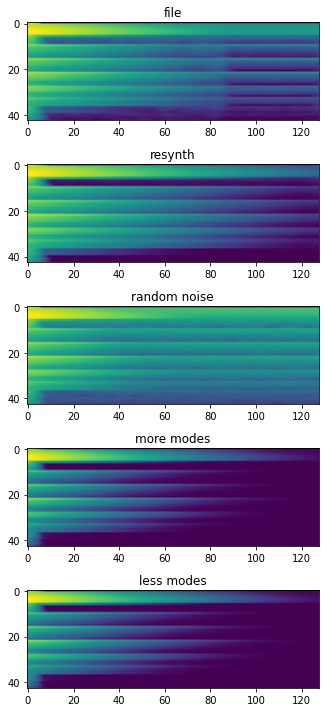

In [181]:
plt.figure(figsize=(6, 10))
plt.subplot(5,1,1)
plt.imshow(Sy_original_log)
plt.title("file")
#plt.colorbar()
plt.subplot(5,1,2)
plt.imshow(Sy_acc_log)
plt.title("resynth")
#plt.colorbar()
plt.subplot(5,1,3)
plt.imshow(Sy_noise)
plt.title("random noise")
#plt.colorbar()
plt.subplot(5,1,4)
plt.imshow(Sy_mode)
plt.title("more modes")
plt.subplot(5,1,5)
plt.imshow(Sy_mode2)
plt.title("less modes")
plt.tight_layout()


In [113]:
sum(sound2-y_acc2)

-0.2667975807109674

In [114]:
sum(sound3-y_acc3)

-0.3796669931231915

In [115]:
ipd.Audio(sound3-y_acc3,rate=22050)

In [108]:
ipd.Audio(y_acc3,rate=22050)